In [ ]:
%pip install pandas numpy networkx matplotlib scikit-learn --quiet

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import random

# Preprocessing dei dati

In [ ]:


df_posts = pd.read_csv("../../../data/post_data.csv")
df_replies = pd.read_csv("../../../data/replies_data.csv")

df = pd.merge(df_posts, df_replies, left_on='Post ID', right_on='Parent Post ID', how='inner', suffixes=('_post', '_reply'))
df.columns = [col.lower().replace(" ", "_") for col in df.columns]
df.head()

,post_id_post,user_id_post,thread_type_post,username_post,profile_picture_url_post,text_post_post,like_count_post,quote_count_post,caption_text_post,direct_reply_count_post,...,caption_text_reply,direct_reply_count_reply,repost_count_reply,following,followed_by,can_reply,reply_control,reshare_count,is_verified,parent_post_id
0,3481594135434044840,62926993725,thread,simolude_ai,https://scontent-fco2-1.cdninstagram.com/v/t51...,Aston Martin for you.\r\n\r\nFor more pics ple...,7,0,Aston Martin for you.\r\n\r\nFor more pics ple...,NaN,...,Aston Martin for you.\r\n\r\nFor more pics ple...,NaN,0.0,False,False,True,everyone,0,False,3481594135434044840
1,3481594135434044840,62926993725,thread,simolude_ai,https://scontent-fco2-1.cdninstagram.com/v/t51...,Aston Martin for you.\r\n\r\nFor more pics ple...,7,0,Aston Martin for you.\r\n\r\nFor more pics ple...,NaN,...,Aston Martin for you.\r\n\r\nFor more pics ple...,NaN,0.0,False,False,True,everyone,0,False,3481594135434044840
2,3481594135434044840,62926993725,thread,simolude_ai,https://scontent-fco2-1.cdninstagram.com/v/t51...,Aston Martin for you.\r\n\r\nFor more pics ple...,7,0,Aston Martin for you.\r\n\r\nFor more pics ple...,NaN,...,Aston Martin for you.\r\n\r\nFor more pics ple...,NaN,0.0,False,False,True,everyone,0,False,3481594135434044840
3,3481594135434044840,62926993725,thread,simolude_ai,https://scontent-fco2-1.cdninstagram.com/v/t51...,Aston Martin for you.\r\n\r\nFor more pics ple...,7,0,Aston Martin for you.\r\n\r\nFor more pics ple...,NaN,...,Aston Martin for you.\r\n\r\nFor more pics ple...,NaN,0.0,False,False,True,everyone,0,False,3481594135434044840
4,3481594135434044840,62926993725,thread,simolude_ai,https://scontent-fco2-1.cdninstagram.com/v/t51...,Aston Martin for you.\r\n\r\nFor more pics ple...,7,0,Aston Martin for you.\r\n\r\nFor more pics ple...,NaN,...,Aston Martin for you.\r\n\r\nFor more pics ple...,NaN,0.0,False,False,True,everyone,0,False,3481594135434044840


In [32]:
df.columns

Index(['post_id_post', 'user_id_post', 'thread_type_post', 'username_post',
       'profile_picture_url_post', 'text_post_post', 'like_count_post',
       'quote_count_post', 'caption_text_post', 'direct_reply_count_post',
       'repost_count_post', 'post_id_reply', 'user_id_reply',
       'thread_type_reply', 'username_reply', 'profile_picture_url_reply',
       'text_post_reply', 'like_count_reply', 'quote_count_reply',
       'caption_text_reply', 'direct_reply_count_reply', 'repost_count_reply',
       'following', 'followed_by', 'can_reply', 'reply_control',
       'reshare_count', 'is_verified', 'parent_post_id'],
      dtype='object')

# Identificazione degli utenti influenti

In [32]:

# Creazione del grafo delle interazioni
G = nx.DiGraph()

# Aggiunta dei nodi e degli archi basati su risposte e repost
for _, row in df.iterrows():
    user_post = row['user_id_post']
    user_reply = row['user_id_reply']
    if user_reply and user_post:  # Se esiste un reply per il post
        G.add_edge(user_reply, user_post, weight=row['like_count_reply'])

#v2
# Inizializza il grafo orientato
G = nx.DiGraph()

# Aggiungi i nodi e gli attributi degli utenti
for _, row in df.iterrows():
    # Aggiunge nodo per l'utente del post, se non esiste già
    if row['user_id_post'] not in G:
        G.add_node(row['user_id_post'], username=row['username_post'], is_verified=row['is_verified'])

    # Aggiunge nodo per l'utente della risposta, se esiste ed è differente dall'autore del post
    if pd.notna(row['user_id_reply']) and row['user_id_reply'] != row['user_id_post']:
        if row['user_id_reply'] not in G:
            G.add_node(row['user_id_reply'], username=row['username_reply'], is_verified=row['is_verified'])

        # Identifica se è un reply o una interazione con un parent post
        if row['parent_post_id'] != row['post_id_post']:
            # Aggiunge un arco dal rispondente all’autore del post originale
            G.add_edge(row['user_id_reply'], row['user_id_post'],
                       type='reply',
                       like_count=row['like_count_reply'],
                       quote_count=row['quote_count_reply'],
                       repost_count=row['repost_count_reply'])

# Opzionalmente, puoi aggiungere pesi agli archi in base alle interazioni (like, quote, repost)
for u, v, data in G.edges(data=True):
    # Calcola il peso come somma ponderata (esempio: 1*like_count + 2*quote_count + 3*repost_count)
    data['weight'] = (data['like_count'] * 1 + data['quote_count'] * 2 + data['repost_count'] * 3)

In [33]:

# Calcolo delle metriche di centralità
centralities = {
    'Degree Centrality': nx.degree_centrality(G),
    'Closeness Centrality': nx.closeness_centrality(G),
    'Betweenness Centrality': nx.betweenness_centrality(G, normalized=True, weight='weight'),
    'PageRank': nx.pagerank(G, alpha=0.85),
    'Katz Centrality': nx.katz_centrality(G, alpha=0.1, beta=1.0, max_iter=1000, tol=1e-06),
    'Eigenvector Centrality': nx.eigenvector_centrality(G, max_iter=1000),
    'HITS Hub Scores': nx.hits(G, max_iter=1000, tol=1e-08)[0],
    'HITS Authority Scores': nx.hits(G, max_iter=1000, tol=1e-08)[1]
}

# Funzione per stampare i top 10 utenti per ciascuna metrica di centralità
def print_top_centralities(centralities, top_n=10):
    for name, values in centralities.items():
        print(f"\nTop {top_n} utenti per {name}:")
        top_nodes = sorted(values.items(), key=lambda x: x[1], reverse=True)[:top_n]
        for i, (node, score) in enumerate(top_nodes, start=1):
            print(f"{i}. Nodo {node}: {score:.4f}")

# Chiamata alla funzione per stampare i risultati
print_top_centralities(centralities)



Top 10 utenti per Degree Centrality:
1. Nodo 62926993725: 0.0000
2. Nodo 38077850387: 0.0000
3. Nodo 1501070805: 0.0000
4. Nodo 65532133383: 0.0000
5. Nodo 24736383042: 0.0000
6. Nodo 56120228996: 0.0000
7. Nodo 7278044187: 0.0000
8. Nodo 2347943083: 0.0000
9. Nodo 8685046141: 0.0000
10. Nodo 3665985737: 0.0000

Top 10 utenti per Closeness Centrality:
1. Nodo 62926993725: 0.0000
2. Nodo 38077850387: 0.0000
3. Nodo 1501070805: 0.0000
4. Nodo 65532133383: 0.0000
5. Nodo 24736383042: 0.0000
6. Nodo 56120228996: 0.0000
7. Nodo 7278044187: 0.0000
8. Nodo 2347943083: 0.0000
9. Nodo 8685046141: 0.0000
10. Nodo 3665985737: 0.0000

Top 10 utenti per Betweenness Centrality:
1. Nodo 62926993725: 0.0000
2. Nodo 38077850387: 0.0000
3. Nodo 1501070805: 0.0000
4. Nodo 65532133383: 0.0000
5. Nodo 24736383042: 0.0000
6. Nodo 56120228996: 0.0000
7. Nodo 7278044187: 0.0000
8. Nodo 2347943083: 0.0000
9. Nodo 8685046141: 0.0000
10. Nodo 3665985737: 0.0000

Top 10 utenti per PageRank:
1. Nodo 62926993725: 

c:\Users\Utente\AppData\Local\Programs\Python\Python310\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:90: RuntimeWarning: invalid value encountered in divide
  h /= h.sum()


# Modellazione della propagazione

#### Linear Threshold

In [34]:
# Aggiungiamo soglie casuali per ogni nodo nel grafo
for node in G.nodes():
    G.nodes[node]['threshold'] = random.uniform(0, 1)  # Soglia tra 0 e 1

# Funzione del modello a soglia lineare
def linear_threshold_model(G, seed_nodes):
    activated = set(seed_nodes)
    newly_activated = set(seed_nodes)

    # Inizializzazione dei pesi degli archi, distribuiti equamente per ogni nodo
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if neighbors:
            # Distribuiamo l'influenza tra i vicini in modo uniforme
            weight = 1 / len(neighbors)
            for neighbor in neighbors:
                G.edges[node, neighbor]['influence'] = weight

    # Propagazione iterativa
    while newly_activated:
        next_activated = set()
        for node in G.nodes():
            if node not in activated:
                # Calcoliamo l'influenza totale dei vicini attivi
                total_influence = sum(G.edges[neighbor, node]['influence'] for neighbor in G.predecessors(node) if neighbor in activated)
                
                # Controlliamo se l'influenza totale supera la soglia del nodo
                if total_influence >= G.nodes[node]['threshold']:
                    next_activated.add(node)

        newly_activated = next_activated
        activated.update(newly_activated)

    return activated

In [35]:
top_influencers = sorted(centralities.get("PageRank").items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Influencers by PageRank:", top_influencers)

seed_nodes = [node for node, _ in top_influencers] 
activated_nodes_lt = linear_threshold_model(G, seed_nodes)

print("Numero totale di nodi attivati (LT Model):", len(activated_nodes_lt))


Top Influencers by PageRank: [(62926993725, 0.00034566194262010023), (38077850387, 0.00034566194262010023), (1501070805, 0.00034566194262010023), (65532133383, 0.00034566194262010023), (24736383042, 0.00034566194262010023), (56120228996, 0.00034566194262010023), (7278044187, 0.00034566194262010023), (2347943083, 0.00034566194262010023), (8685046141, 0.00034566194262010023), (3665985737, 0.00034566194262010023)]
Numero totale di nodi attivati (LT Model): 10


#### Independent Cascade

In [17]:
def independent_cascade_model(G, seed_nodes, p=0.1):
    activated = set(seed_nodes)
    newly_activated = set(seed_nodes)

    while newly_activated:
        next_activated = set()
        for node in newly_activated:
            neighbors = set(G.neighbors(node)) - activated
            for neighbor in neighbors:
                if np.random.rand() < p:  # probabilità di attivazione
                    next_activated.add(neighbor)
        newly_activated = next_activated
        activated.update(newly_activated)

    return activated


In [36]:
# Selezione degli utenti più influenti
top_influencers = sorted(centralities.get("PageRank").items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Influencers by PageRank:", top_influencers)

# Simulazione con il modello IC
seed_nodes = [node for node, _ in top_influencers]
activated_nodes = independent_cascade_model(G, seed_nodes)
print("Numero totale di nodi attivati:", len(activated_nodes))


Top Influencers by PageRank: [(62926993725, 0.00034566194262010023), (38077850387, 0.00034566194262010023), (1501070805, 0.00034566194262010023), (65532133383, 0.00034566194262010023), (24736383042, 0.00034566194262010023), (56120228996, 0.00034566194262010023), (7278044187, 0.00034566194262010023), (2347943083, 0.00034566194262010023), (8685046141, 0.00034566194262010023), (3665985737, 0.00034566194262010023)]
Numero totale di nodi attivati: 10


# Massimizzazione dell'influenza

In [20]:
# Funzione di valutazione dell'influenza (generica per IC o LT)
def evaluate_spread(G, seed_nodes, model="IC", activation_prob=0.1):
    """
    Valuta la diffusione dell'influenza utilizzando il modello IC o LT.
    Params:
    - G: grafo orientato.
    - seed_nodes: lista di nodi seed.
    - model: modello di diffusione ("IC" o "LT").
    - activation_prob: probabilità di attivazione per il modello IC.

    Returns:
    - Il numero di nodi attivati.
    """
    if model == "IC":
        return len(independent_cascade_model(G, seed_nodes, activation_prob))
    elif model == "LT":
        return len(linear_threshold_model(G, seed_nodes))
    else:
        raise ValueError("Modello non supportato. Usa 'IC' o 'LT'.")


# Algoritmo Greedy per la Massimizzazione dell'Influenza
def influence_maximization_greedy(G, k, model="IC", activation_prob=0.1):
    """
    Algoritmo Greedy per la massimizzazione dell'influenza.
    Params:
    - G: grafo orientato.
    - k: numero di nodi seed da selezionare.
    - model: modello di diffusione ("IC" o "LT").
    - activation_prob: probabilità di attivazione per il modello IC.

    Returns:
    - best_seeds: lista di nodi seed selezionati.
    """
    best_seeds = []
    all_nodes = set(G.nodes())

    for _ in range(k):
        max_influence = -1
        best_node = None

        for node in all_nodes - set(best_seeds):
            spread = evaluate_spread(G, best_seeds + [node], model, activation_prob)
            if spread > max_influence:
                max_influence = spread
                best_node = node

        best_seeds.append(best_node)

    return best_seeds


# Algoritmo CELF per la Massimizzazione dell'Influenza
def influence_maximization_celf(G, k, model="IC", activation_prob=0.1):
    """
    Algoritmo CELF (Cost-Effective Lazy Forward) per la massimizzazione dell'influenza.
    Params:
    - G: grafo orientato.
    - k: numero di nodi seed da selezionare.
    - model: modello di diffusione ("IC" o "LT").
    - activation_prob: probabilità di attivazione per il modello IC.

    Returns:
    - best_seeds: lista di nodi seed selezionati.
    """
    # Lista delle influenze marginali per ciascun nodo
    marginals = []
    best_seeds = []
    all_nodes = set(G.nodes())

    # Prima valutazione per ogni nodo
    for node in all_nodes:
        spread = evaluate_spread(G, [node], model, activation_prob)
        marginals.append((spread, node))
    marginals.sort(reverse=True, key=lambda x: x[0])

    for _ in range(k):
        while True:
            # Prendi il nodo con la massima influenza marginale
            spread, node = marginals[0]
            # Ricalcola l'influenza marginale se è obsoleto
            new_spread = evaluate_spread(G, best_seeds + [node], model, activation_prob)
            marginals[0] = (new_spread, node)
            marginals.sort(reverse=True, key=lambda x: x[0])

            # Se il nodo in testa è aggiornato, lo seleziona
            if marginals[0][1] == node:
                best_seeds.append(node)
                marginals.pop(0)
                break

    return best_seeds




In [37]:

# Esempio di esecuzione della massimizzazione dell'influenza
k = 10  # Numero di nodi seed da selezionare
best_seeds_greedy = influence_maximization_greedy(G, k, model="IC")
best_seeds_celf = influence_maximization_celf(G, k, model="IC")

print(f"Miglior set di nodi iniziali con algoritmo Greedy (k={k}):", best_seeds_greedy)
print(f"Miglior set di nodi iniziali con algoritmo CELF (k={k}):", best_seeds_celf)

Miglior set di nodi iniziali con algoritmo Greedy (k=10): [7321698307, 65532133383, 601538568, 46473871369, 45617037320, 53856575502, 1277966, 1543143439, 37052383249, 318414866]
Miglior set di nodi iniziali con algoritmo CELF (k=10): [7321698307, 65532133383, 601538568, 46473871369, 45617037320, 53856575502, 1277966, 1543143439, 37052383249, 318414866]


# Visualizzazione

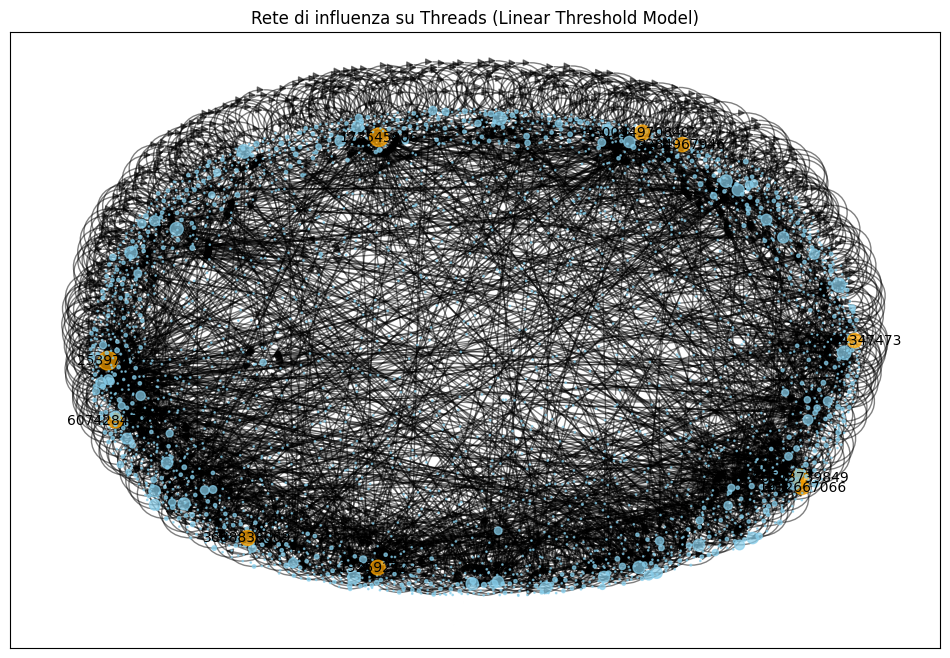

In [ ]:

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.15)
node_colors = ["orange" if node in activated_nodes_lt else "skyblue" for node in G.nodes()]
node_sizes = [centralities.get("PageRank")[node] * 10000 for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, {node: node for node, _ in top_influencers}, font_size=10)
plt.title("Rete di influenza su Threads (Linear Threshold Model)")
plt.show()